In [1]:
%pwd

'/Users/peiboxu/Desktop/merge-seq analysis/elife_revision/code_file'

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False,fontsize=10,dpi_save=300,format='pdf')  # low dpi (dots per inch) yields small inline figures
plt.rcParams['font.sans-serif']=['Arial']
plt.rcParams['pdf.fonttype'] = 'truetype'

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 9.5.0
anyio               NA
appnope             0.1.3
arrow               1.2.3
asttokens           NA
attr                23.1.0
babel               2.12.1
backcall            0.2.0
certifi             2023.05.07
cffi                1.15.1
charset_normalizer  3.1.0
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
executing           1.2.0
fastjsonschema      NA
fqdn                NA
h5py                3.9.0
idna                3.4
importlib_resources NA
ipykernel           6.23.3
ipython_genutils    0.2.0
ipywidgets          8.0.6
isoduration         NA
jedi                0.18.2
jinja2              3.1.2
joblib              1.3.0
json5               NA
jsonpointer         2.4
jsonschema          4.17.3
jupyter_events      0.6.3
jupyter_server      2.7.0
jupyterlab_server   2.23.0
kiwis

# import loom file

In [ ]:
## read loom file for first time, next time, load h5ad file

adata=sc.read_loom('/home/xupb/scRNA_data/mouse_pfc/manuscripts/pfc_seu_merge_loom_bar5.loom')

In [ ]:
adata

# import PCs and HVGs

In [ ]:
adata.obsm['X_pca']=adata.obsm['pca_cell_embeddings']

In [ ]:
adata.var['highly_variable']=adata.var['Selected'].astype('bool')

In [ ]:
results_file = './write/pfc_seurat_merge.h5ad'
adata.write(results_file) 

In [ ]:
adata=sc.read_h5ad('./write/pfc_seurat_merge.h5ad')

# Run umap and leiden cluster

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

In [ ]:
sc.tl.leiden(adata,resolution =0.1)
sc.tl.umap(adata)

In [ ]:
sc.tl.tsne(adata,n_pcs=50)

In [ ]:
sc.pl.umap(adata, color=['leiden','louvain','facs'],use_raw=False,legend_loc='on data')

# merge clusters, corase clustering

In [ ]:

adata.obs['leiden_number'] = adata.obs['leiden']
adata.obs['leiden_coarse'] = adata.obs['leiden_number']

old_to_new = {'0':'Excitatory','1':'Excitatory','7':'Excitatory','11':'Excitatory','14':'Excitatory',
              '2': 'Microglia', '3':'Endo','8':'Endo','4':'Oligo', '5':'OPC','12':'OPC',
              '6': 'Inhibitory','10':'Inhibitory','9':'Astro',
              '13':'Act.Microglia','15':'Endo'}
    
adata.obs['leiden_coarse'] = (
    adata.obs['leiden_number']
    .map(old_to_new)
    .astype('category')
)

In [ ]:
adata.obs['leiden_coarse'].value_counts()

In [ ]:
adata.obs['leiden_coarse'].cat.categories

In [ ]:
adata.obs['leiden_coarse'].cat.reorder_categories(['Excitatory','Microglia', 'Endo',
                                                    'OPC','Oligo','Inhibitory',
                                                    'Astro','Act.Microglia'], inplace = True)

In [ ]:
## extract cluster color code
adata.uns['leiden_coarse_colors']

In [ ]:
sc.settings.set_figure_params(dpi=80, frameon=False,fontsize=20,dpi_save=300,format='pdf')  # low dpi (dots per inch) yields small inline figures
plt.rcParams['font.sans-serif']=['Arial']
plt.rcParams['pdf.fonttype'] = 'truetype'
sc.pl.tsne(adata, color=['leiden'],title='',palette=sc.pl.palettes.godsnot_64,legend_loc='',
           size=30,save=' tsne schematics for fig1.pdf'
          )

In [ ]:
rcParams["legend.markerscale"] = 3.0
sc.pl.umap(adata, color=['leiden_coarse'],title='',
           legend_fontsize ='large',
           size=30,palette=sc.pl.palettes.vega_20,save=' all cell leiden corase clustering.pdf')

In [ ]:
## manually change 
adata.uns['facs_colors']=['limegreen','grey']

In [ ]:
rcParams["legend.markerscale"] = 3.0
sc.pl.umap(adata, color=['facs'],title='',
           legend_fontsize ='large',
           size=10,save=' all cell facs cluster.pdf'
          )

In [ ]:
results_file = './write/pfc_seurat_merge_anno.h5ad'
adata.write(results_file)

In [ ]:
adata=sc.read_h5ad( '/Users/peiboxu/Desktop/merge-seq analysis/elife_revision/data_file/pfc_seurat_merge_anno.h5ad')

In [ ]:
# export meta info
adata.obs.to_csv('pfc_seurat_merge_meta.csv')

In [ ]:
adata

In [ ]:
meta_valid_barcoded=pd.read_csv('/home/xupb/scRNA_data/mouse_pfc/manuscripts/scanpy/pfc_all_meta_barcoded.csv',
                       index_col=0)

In [ ]:
meta_valid_barcoded['barcoded'].value_counts()

In [ ]:
bdata=adata.copy()

In [ ]:
bdata.obs=meta_valid_barcoded

In [ ]:
ax = sc.pl.umap(bdata, size=70, show=False)
rcParams["legend.markerscale"] = 3.0

sc.pl.umap(
    bdata[bdata.obs["barcoded"] == "Barcoded"],
    size=8,
    color='barcoded',title='Barcoded',legend_fontsize ='large',
    ax=ax,
    save=' all valid cells.pdf'
)


In [ ]:
plt.rcParams['font.sans-serif']=['Helvetica']

In [ ]:
## violin plot of cell type markers
marker_genes=["Slc17a7",'Neurod6',
               'C1qa','C1qb','C1qc',
              'Itm2a','Cldn5',#endothelial cell
              'Vtn',# smooth muscle cell Slc6a20a
            "Olig1",'Olig2', 'Mbp','Mog',
               "Gad1",'Gad2',
            'Sox9','Aldh1l1',# Astrocyte
               'Pf4','Mrc1'
             ]
sc.pl.stacked_violin(adata, marker_genes,layer='norm_data',
                          figsize=(8,8),row_palette=sc.pl.palettes.vega_20,
                     swap_axes=False,
                          groupby='leiden_coarse',save='violin all cluster markers.pdf')

In [ ]:
adata=sc.read_h5ad( '/Users/peiboxu/Desktop/merge-seq analysis/elife_revision/data_file/pfc_seurat_merge_anno.h5ad')

/Users/peiboxu/mambaforge/envs/shap/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/peiboxu/mambaforge/envs/shap/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [ ]:
adata

AnnData object with n_obs × n_vars = 21261 × 20595
    obs: 'ClusterID', 'ClusterName', 'facs', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'percent_rp', 'sample', 'louvain', 'leiden', 'leiden_number', 'leiden_coarse'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'highly_variable'
    uns: 'facs_colors', 'leiden', 'leiden_coarse_colors', 'leiden_colors', 'leiden_number_colors', 'louvain', 'louvain_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'pca_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'
    obsp: 'distances', 'connectivities'

In [ ]:
meta_valid_barcoded=pd.read_csv('/Users/peiboxu/Desktop/merge-seq analysis/elife_revision/results/pfc_all_meta_barcoded.csv',index_col=0)
meta_valid_barcoded['barcoded'].value_counts()

Non-barcoded    17899
Barcoded         2148
Name: barcoded, dtype: int64

In [ ]:
## filter adata with rows of meta_valid_barcoded ##
adata=adata[meta_valid_barcoded.index,:]
adata.obs=meta_valid_barcoded
adata

AnnData object with n_obs × n_vars = 20047 × 20595
    obs: 'ClusterID', 'ClusterName', 'facs', 'nCount_RNA', 'nFeature_RNA', 'orig_ident', 'percent_mt', 'percent_rp', 'sample', 'louvain', 'leiden', 'leiden_number', 'leiden_coarse', 'barcoded'
    var: 'Selected', 'vst_mean', 'vst_variable', 'vst_variance', 'vst_variance_expected', 'vst_variance_standardized', 'highly_variable'
    uns: 'facs_colors', 'leiden', 'leiden_coarse_colors', 'leiden_colors', 'leiden_number_colors', 'louvain', 'louvain_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'pca_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'
    obsp: 'distances', 'connectivities'

/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


/Users/peiboxu/opt/anaconda3/envs/shap/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


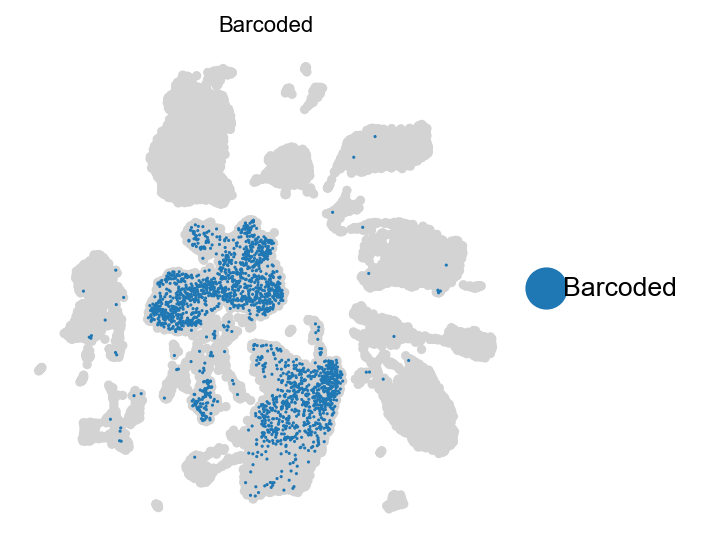

In [ ]:
ax = sc.pl.umap(adata, size=70, show=False)
rcParams["legend.markerscale"] = 3.0

sc.pl.umap(
    adata[adata.obs["barcoded"] == "Barcoded"],
    size=8,
    color='barcoded',title='Barcoded',legend_fontsize ='large',
    ax=ax,
    save=' fig1 all valid cells.pdf'
)

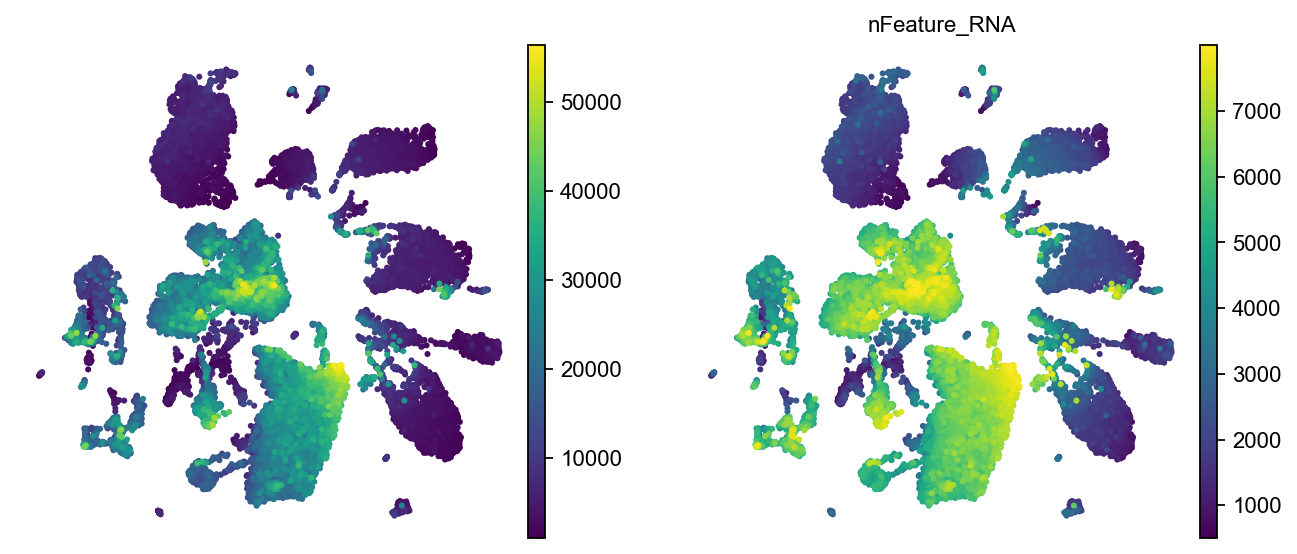

In [6]:
sc.pl.umap(adata, color=['nCount_RNA',"nFeature_RNA"],title='',
           legend_fontsize ='large',
           size=30)